In [116]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import ndimage
import cv2 as cv
from sklearn.model_selection import train_test_split
import time
import os
from sklearn.utils import shuffle
from IPython.display import clear_output
import seaborn as sns

In [3]:
# Importing the list of filepath and image metadata (Manually Annotated part 1):
file_list1 = pd.read_csv('/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_file_lists/training.csv')

# Importing the list of filepath and image metadata (Manually Annotated part 2):
file_list2 = pd.read_csv('/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_file_lists/validation.csv')

In [4]:
file_list = pd.concat([file_list1,file_list2]).reset_index(drop = True)

In [5]:
file_list.head(3)

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,689/737db2483489148d783ef278f43f486c0a97e140fc...,134,134,899,899,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,1,0.785714,-0.055556
1,392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b5532...,20,20,137,137,28.82;77.52;29.12;93.25;31.04;108.51;33.03;123...,0,-0.017253,0.004313
2,468/21772b68dc8c2a11678c8739eca33adb6ccc658600...,11,11,176,176,30.52;87.33;32.55;106.43;36.94;125.81;43.06;14...,0,0.174603,0.007937


In [6]:
# Drop a corrupted file:
file_list[file_list['subDirectory_filePath'] == '103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
235929,103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67...,0,0,161,161,8.17;60.0;10.92;81.3;13.7;101.4;17.72;120.78;2...,10,-2.0,-2.0


In [7]:
file_list = file_list.drop(235929)

In [8]:
file_list.shape

(420298, 9)

In [9]:
expression_classes = pd.DataFrame([[0, 'Neutral'], [1, 'Happiness'], [2, 'Sadness'], [3, 'Surprise'], [4, 'Fear'], 
                                   [5, 'Disgust'], [6, 'Anger'], [7, 'Contempt'], [8, 'None'], 
                                   [9, 'Uncertain'], [10, 'No-Face']], 
                                  columns = ['code', 'expression name'])
expression_classes

,code,expression name
0,0,Neutral
1,1,Happiness
2,2,Sadness
3,3,Surprise
4,4,Fear
5,5,Disgust
6,6,Anger
7,7,Contempt
8,8,None
9,9,Uncertain


In [10]:
file_list.groupby('expression').count()\
    .join(expression_classes)\
        .loc[:,['subDirectory_filePath', 'expression name']]\
            .sort_values('subDirectory_filePath', ascending = False)

,subDirectory_filePath,expression name
expression,,
1,134915,Happiness
10,82914,No-Face
0,75374,Neutral
8,33588,None
2,25959,Sadness
6,25382,Anger
3,14590,Surprise
9,12145,Uncertain
4,6878,Fear


In [11]:
file_list_filtered = file_list[file_list['expression'].isin([1,2])].reset_index(drop = True)

In [42]:
file_list_filtered.groupby('expression').count()\
    .join(expression_classes)\
        .loc[:,['subDirectory_filePath', 'expression name']]\
            .sort_values('subDirectory_filePath', ascending = False)

,subDirectory_filePath,expression name
expression,,
1,134915,Happiness
2,25959,Sadness


Labelled as: Happiness
Shape:  (992, 992, 3)


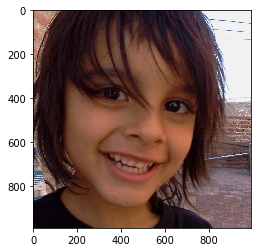

In [12]:
index = 223

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
sample_image = cv.imread(root_dir + file_list_filtered['subDirectory_filePath'][index])
plt.imshow(cv.cvtColor(sample_image, cv.COLOR_BGR2RGB));
print('Labelled as: '+ expression_classes.loc[file_list_filtered['expression'][index], 'expression name'])
print('Shape: ', sample_image.shape)

In [11]:
file_list_filtered.head(3)

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,689/737db2483489148d783ef278f43f486c0a97e140fc...,134,134,899,899,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,1,0.785714,-0.055556
1,944/06e9ae8d3b240eb68fa60534783eacafce2def60a8...,40,40,269,269,44.43;158.17;47.08;189.2;50.54;221.88;58.3;253...,1,0.153401,0.038890
2,981/5c991a28b5550cf5e1e830d5eed1dc7f80581462d6...,35,35,236,236,46.5;134.89;47.28;158.87;51.45;182.31;58.37;20...,1,0.547918,0.249054


In [13]:
#sample_Neutral = file_list_filtered[file_list_filtered['expression'] == 0].sample(10000)
sample_Happiness = file_list_filtered[file_list_filtered['expression'] == 1].sample(10000)
sample_Sadness = file_list_filtered[file_list_filtered['expression'] == 2].sample(10000)
#sample_Anger = file_list_filtered[file_list_filtered['expression'] == 6].sample(10000)

#sample_list = shuffle(pd.concat([sample_Neutral, sample_Happiness, sample_Sadness, sample_Anger])).reset_index()
sample_list = shuffle(pd.concat([sample_Happiness, sample_Sadness])).reset_index()

In [15]:
sample_list.head(3)

,index,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,36359,736/e3a46711c4a6c01cb6dc092be83081e41711c6cda8...,152,152,1019,1019,296.68;512.12;290.69;617.4;293.65;728.58;305.5...,1,0.682540,-0.015873
1,160370,918/725640e7fbd1534dc9d19e7b87c6ae86d60648012c...,21,21,141,141,21.4;79.15;20.67;95.31;21.6;112.49;24.08;128.2...,1,0.667828,0.053233
2,144638,485/523daa172b5ca4f6a0de3980b15d40159452c9bee6...,38,38,256,256,35.01;132.03;37.29;164.4;44.8;196.87;52.59;225...,2,-0.904956,-0.169377


In [ ]:
root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
images = []

counter = 0

for filepath in sample_list['subDirectory_filePath']:
    im = cv.imread(root_dir + filepath)
    
    if len(im.shape) == 3:        # Converting to greyscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if im.shape != (100, 100):    # Resizing to 100 x 100
        im = cv.resize(im, (100, 100))

    images.append(im)
    counter += 1
    if counter % 1000 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
images = np.asarray(images)

In [66]:
expressions = sample_list['expression']

In [35]:
np.save('sample_images_happy_sad_20000.npy', images)
np.save('sample_expressions_happy_sad_20000.npy', expressions)

In [17]:
images = np.load('sample_images_happy_sad_20000.npy')
expressions = np.load('sample_expressions_happy_sad_20000.npy')

Labelled as: Happiness
Shape:  (100, 100)


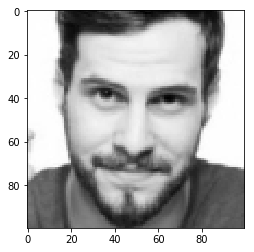

In [34]:
index = 9897

plt.imshow(images[index], cmap = 'gray');
print('Labelled as: '+ expression_classes.loc[expressions[index], 'expression name'])
print('Shape: ', images[index].shape)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, expressions, 
                                                    test_size=0.1, random_state=1, stratify = expressions)

X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

X_train_CNN = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_train_CNN = np.asarray(pd.get_dummies(y_train))
y_test_CNN = np.asarray(pd.get_dummies(y_test))

Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995


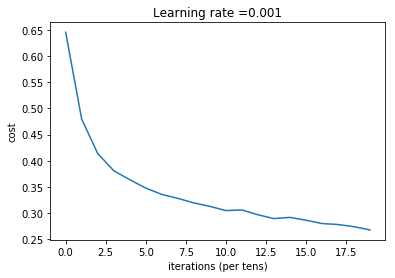

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.88722223
Test Accuracy: 0.857


In [45]:
# With learning_rate = 0.001, num_epochs = 20, minibatch_size = 100
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)

Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995
Cost after epoch 20: 0.267799
Cost after epoch 22: 0.263054
Cost after epoch 24: 0.255528
Cost after epoch 26: 0.250371
Cost after epoch 28: 0.246642
Cost after epoch 30: 0.244370
Cost after epoch 32: 0.239628
Cost after epoch 34: 0.233860
Cost after epoch 36: 0.230624
Cost after epoch 38: 0.229043


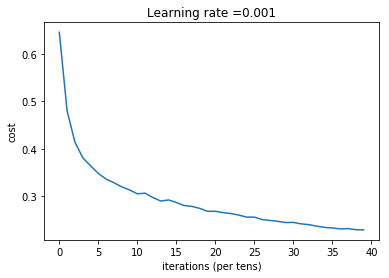

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.90088886
Test Accuracy: 0.864


In [55]:
# With learning_rate = 0.001, num_epochs = 40, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [61]:
print(f'Training time: {((end-start)/60):0.3} min')

Training time: 25.6 min


Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995
Cost after epoch 20: 0.267799
Cost after epoch 22: 0.263054
Cost after epoch 24: 0.255528
Cost after epoch 26: 0.250371
Cost after epoch 28: 0.246642
Cost after epoch 30: 0.244370
Cost after epoch 32: 0.239628
Cost after epoch 34: 0.233860
Cost after epoch 36: 0.230624
Cost after epoch 38: 0.229043
Cost after epoch 40: 0.225432
Cost after epoch 42: 0.225191
Cost after epoch 44: 0.221195
Cost after epoch 46: 0.217818
Cost after epoch 48: 0.221650
Cost after epoch 50: 0.213340
Cost after epoch 52: 0.211846
Cost after epoch 54: 0.207401
Cost after epoch 56: 0.205131
Cost after epoch 58: 0.204884
Cost after epoch 60: 0.203312
Cost after epoch 62: 0.201462
Cost after epoch 64: 0.197219
Cost after epoc

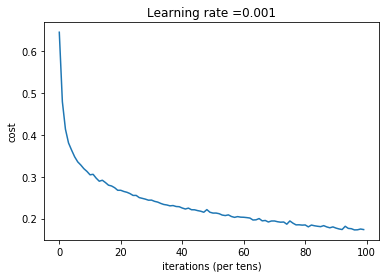

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9407222
Test Accuracy: 0.8555


In [64]:
# With learning_rate = 0.001, num_epochs = 100, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [65]:
print(f'Training time: {((end-start)/60):0.3} min')

Training time: 62.7 min


In [43]:
# With 3 expressions:
file_list_filtered = file_list[file_list['expression'].isin([1,2, 10])].reset_index(drop = True)
sample_NoFace = file_list_filtered[file_list_filtered['expression'] == 10].sample(10000)
sample_Happiness = file_list_filtered[file_list_filtered['expression'] == 1].sample(10000)
sample_Sadness = file_list_filtered[file_list_filtered['expression'] == 2].sample(10000)

sample_list = shuffle(pd.concat([sample_NoFace, sample_Happiness, sample_Sadness])).reset_index()

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
images = []

counter = 0

for filepath in sample_list['subDirectory_filePath']:
    im = cv.imread(root_dir + filepath)
    
    if len(im.shape) == 3:        # Converting to greyscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if im.shape != (100, 100):    # Resizing to 100 x 100
        im = cv.resize(im, (100, 100))

    images.append(im)
    counter += 1
    if counter % 1000 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
images = np.asarray(images)

expressions = sample_list['expression']

Image 30000 processed


In [44]:
np.save('sample_images_happy_sad_noface_10000each.npy', images)
np.save('sample_expressions_happy_sad_noface_10000each.npy', expressions)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(images, expressions, 
                                                    test_size=0.1, random_state=1, stratify = expressions)

X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

X_train_CNN = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_train_CNN = np.asarray(pd.get_dummies(y_train))
y_test_CNN = np.asarray(pd.get_dummies(y_test))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.026665
Cost after epoch 2: 0.830532
Cost after epoch 4: 0.775392
Cost after epoch 6: 0.738116
Cost after epoch 8: 0.721058
Cost after epoch 10: 0.694487
Cost after epoch 12: 0.679098
Cost after epoch 14: 0.669616
Cost after epoch 16: 0.659589
Cost after epoch 18: 0.652378


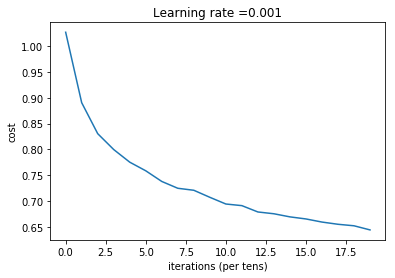

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7320741
Test Accuracy: 0.692


In [47]:
# With learning_rate = 0.001, num_epochs = 20, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

Cost after epoch 0: 1.026665
Cost after epoch 2: 0.830532
Cost after epoch 4: 0.775392
Cost after epoch 6: 0.738116
Cost after epoch 8: 0.721058
Cost after epoch 10: 0.694487
Cost after epoch 12: 0.679098
Cost after epoch 14: 0.669616
Cost after epoch 16: 0.659589
Cost after epoch 18: 0.652378
Cost after epoch 20: 0.638646
Cost after epoch 22: 0.631264
Cost after epoch 24: 0.630462
Cost after epoch 26: 0.618659
Cost after epoch 28: 0.610942
Cost after epoch 30: 0.604370
Cost after epoch 32: 0.600387
Cost after epoch 34: 0.598679
Cost after epoch 36: 0.593229
Cost after epoch 38: 0.594727
Cost after epoch 40: 0.586769
Cost after epoch 42: 0.584483
Cost after epoch 44: 0.576087
Cost after epoch 46: 0.574923
Cost after epoch 48: 0.568158


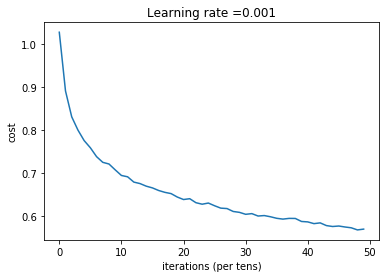

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.772037
Test Accuracy: 0.70166665


In [49]:
# With learning_rate = 0.001, num_epochs = 50, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [1]:
# Impoting from script file
from CNN_functions import *

In [ ]:
# With learning_rate = 0.001, num_epochs = 50, minibatch_size = 100
start = time.time()
_, _, parameters = CNN_model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [13]:
# Importing all images and converting to 100x100 grayscale:

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
all_images = []

counter = 0

for filepath in file_list['subDirectory_filePath']:
    im = cv.imread(root_dir + filepath)
    
    if len(im.shape) == 3:        # Converting to greyscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if im.shape != (100, 100):    # Resizing to 100 x 100
        im = cv.resize(im, (100, 100))

    all_images.append(im)
    counter += 1
    if counter % 1000 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
all_images = np.asarray(all_images)

all_expressions = file_list['expression']

# np.save('all_images.npy', all_images)
# np.save('all_expressions.npy', all_expressions)

Image 420000 processed


Labelled as: Happiness
Shape:  (100, 100)


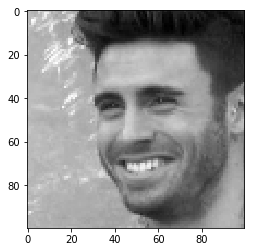

In [47]:
index = 14955

plt.imshow(all_images[index], cmap = 'gray');
print('Labelled as: '+ expression_classes.loc[all_expressions[index], 'expression name'])
print('Shape: ', all_images[index].shape)

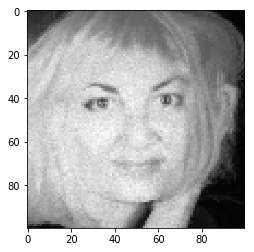

In [297]:
for im in all_images[all_expressions == 1][1:2]:
    plt.imshow(im, cmap = 'gray')
    plt.show()

In [254]:
# Importing all images and converting to 100x100 grayscale:

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
large_images = []

counter = 0

for filepath in file_list['subDirectory_filePath'][1:1000]:
    im = cv.imread(root_dir + filepath)
    
#     if len(im.shape) == 3:        # Converting to greyscale
#         im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
#     if im.shape != (1000, 1000):    # Resizing to 100 x 100
#         im = cv.resize(im, (1000, 1000))

    large_images.append(im)
    counter += 1
    if counter % 10 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
large_images = np.asarray(large_images)

large_expressions = file_list['expression'][1:1000]

# np.save('all_images.npy', all_images)
# np.save('all_expressions.npy', all_expressions)

Image 990 processed


In [236]:
file_list[file_list['expression'] == 10].iloc[19,:]

subDirectory_filePath    732/0c104f861e7c5cb019a0710aa9028c607f6a632dee...
face_x                                                                 166
face_y                                                                 166
face_width                                                            1111
face_height                                                           1111
facial_landmarks         314.95;658.71;317.59;784.32;325.61;909.54;344....
expression                                                              10
valence                                                                 -2
arousal                                                                 -2
Name: 77, dtype: object

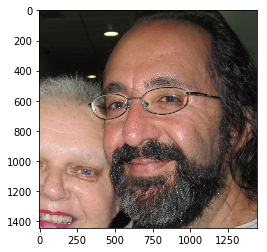

In [232]:
plt.imshow(cv.cvtColor(large_images[large_expressions == 10][19], cv.COLOR_BGR2RGB))

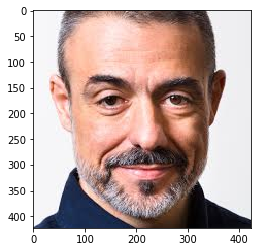

In [264]:
plt.imshow(cv.cvtColor(large_images[large_expressions == 7][2], cv.COLOR_BGR2RGB))

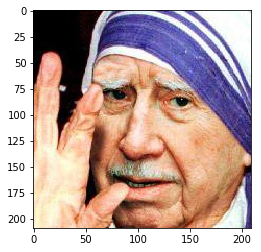

In [284]:
for im in large_images[large_expressions == 2][0:1]:
    plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    plt.show()

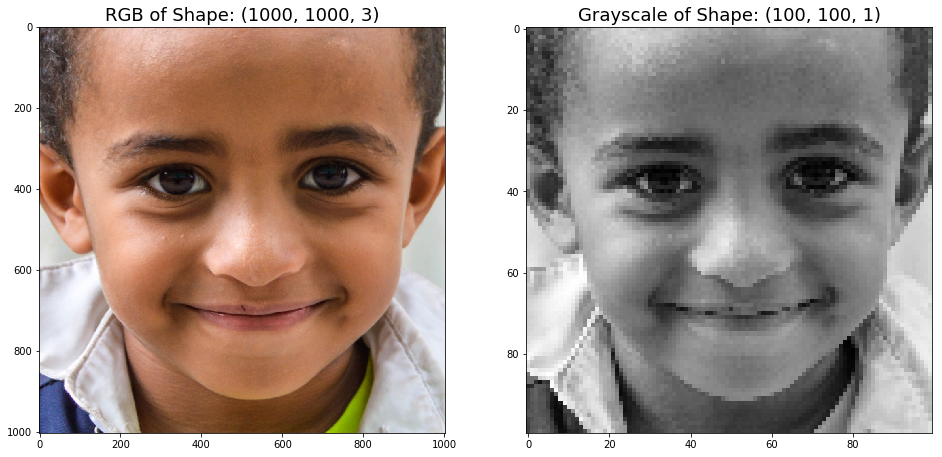

In [292]:
# Compression:
plt.figure(figsize = (16,8))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.imshow(cv.cvtColor(large_images[large_expressions == 1][18], cv.COLOR_BGR2RGB))
plt.title('RGB of Shape: (1000, 1000, 3)', fontsize=18)

plt.subplot2grid((1,2), (0,1))
plt.imshow(all_images[all_expressions == 1][19], cmap = 'gray');
plt.title('Grayscale of Shape: (100, 100, 1)', fontsize=18);

plt.savefig('compression.png')

In [119]:
expression_dist = file_list.groupby('expression').count()\
    .join(expression_classes)\
        .loc[:,['subDirectory_filePath', 'expression name']]\
            .sort_values('subDirectory_filePath', ascending = False)

expression_dist

,subDirectory_filePath,expression name
expression,,
1,134915,Happiness
10,82914,No-Face
0,75374,Neutral
8,33588,None
2,25959,Sadness
6,25382,Anger
3,14590,Surprise
9,12145,Uncertain
4,6878,Fear


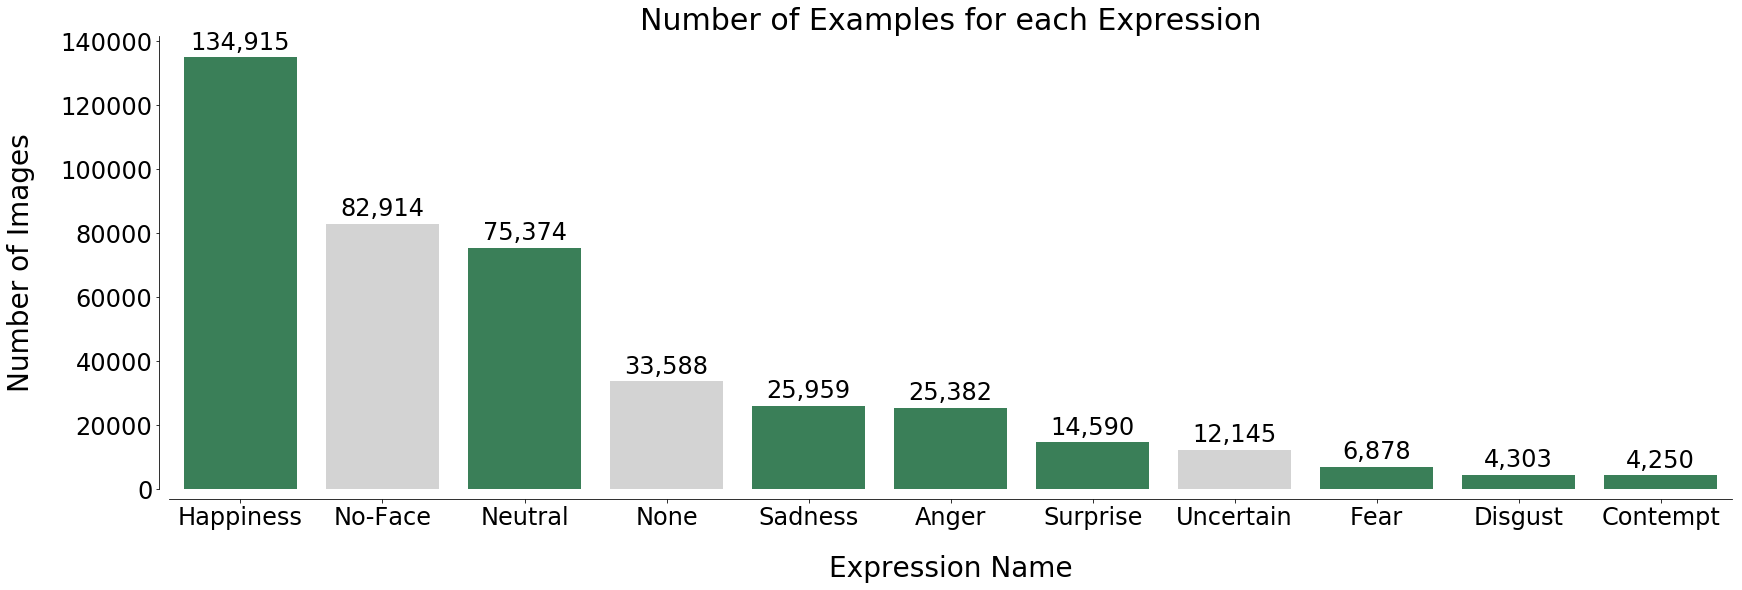

In [290]:
x = expression_dist['expression name']
y = expression_dist['subDirectory_filePath']
custom_colors = ['lightgrey' if (i in ['No-Face', 'None', 'Uncertain']) else 'seagreen' for i in x]

plt.figure(figsize = (24,8))

sns.barplot(x, y, palette=custom_colors)
sns.despine(offset=10, trim=False)

plt.title('Number of Examples for each Expression', fontsize=30);
plt.xlabel('Expression Name', fontsize=28, labelpad=25)
plt.ylabel('Number of Images', fontsize=28, labelpad=25)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout(pad=0)


for i, v in enumerate(y):
    plt.text(i, v + 2500, "{:,}".format(v), color='black', ha='center', fontsize=24);

plt.savefig('expression_dist.png')

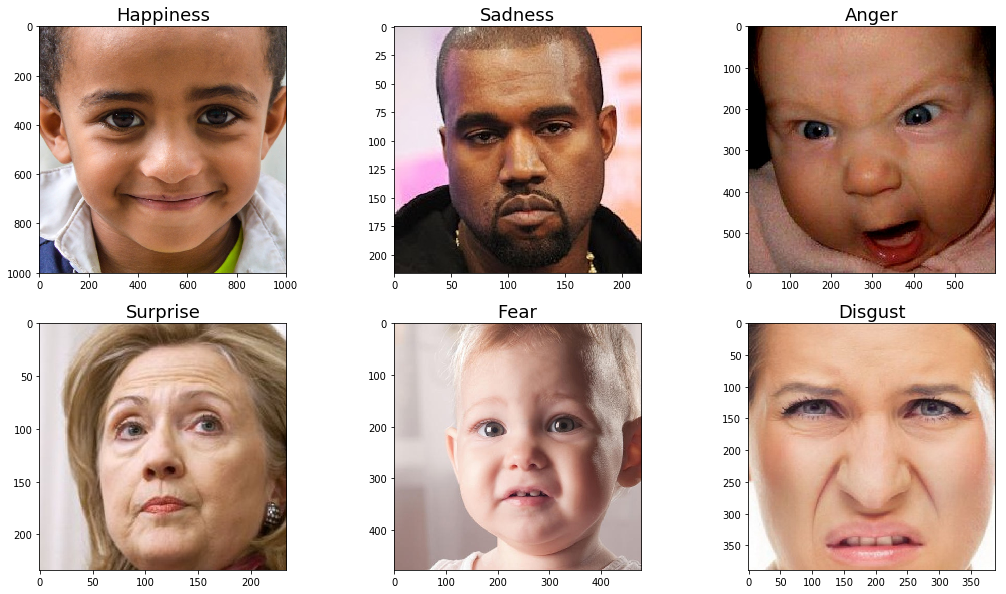

In [291]:
# Examples of Expressions:
plt.figure(figsize = (18,10))
gridspec.GridSpec(2,3)

plt.subplot2grid((2,3), (0,0))
plt.imshow(cv.cvtColor(large_images[large_expressions == 1][18], cv.COLOR_BGR2RGB))
plt.title('Happiness', fontsize=18);

plt.subplot2grid((2,3), (0,1))
plt.imshow(cv.cvtColor(large_images[large_expressions == 2][2], cv.COLOR_BGR2RGB))
plt.title('Sadness', fontsize=18);

plt.subplot2grid((2,3), (0,2))
plt.imshow(cv.cvtColor(large_images[large_expressions == 6][62], cv.COLOR_BGR2RGB))
plt.title('Anger', fontsize=18);

plt.subplot2grid((2,3), (1,0))
plt.imshow(cv.cvtColor(large_images[large_expressions == 3][13], cv.COLOR_BGR2RGB))
plt.title('Surprise', fontsize=18);

plt.subplot2grid((2,3), (1,1))
plt.imshow(cv.cvtColor(large_images[large_expressions == 4][2], cv.COLOR_BGR2RGB))
plt.title('Fear', fontsize=18);

plt.subplot2grid((2,3), (1,2))
plt.imshow(cv.cvtColor(large_images[large_expressions == 5][3], cv.COLOR_BGR2RGB))
plt.title('Disgust', fontsize=18);

plt.savefig('samples.png')

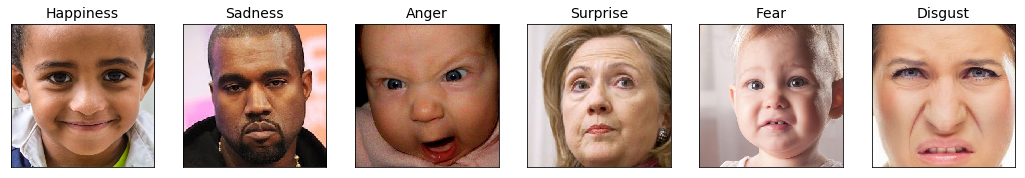

In [296]:
# Examples of Expressions:
plt.figure(figsize = (18,5))
gridspec.GridSpec(1,6)

plt.subplot2grid((1,6), (0,0))
plt.imshow(cv.cvtColor(large_images[large_expressions == 1][18], cv.COLOR_BGR2RGB))
plt.title('Happiness', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.subplot2grid((1,6), (0,1))
plt.imshow(cv.cvtColor(large_images[large_expressions == 2][2], cv.COLOR_BGR2RGB))
plt.title('Sadness', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.subplot2grid((1,6), (0,2))
plt.imshow(cv.cvtColor(large_images[large_expressions == 6][62], cv.COLOR_BGR2RGB))
plt.title('Anger', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.subplot2grid((1,6), (0,3))
plt.imshow(cv.cvtColor(large_images[large_expressions == 3][13], cv.COLOR_BGR2RGB))
plt.title('Surprise', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.subplot2grid((1,6), (0,4))
plt.imshow(cv.cvtColor(large_images[large_expressions == 4][2], cv.COLOR_BGR2RGB))
plt.title('Fear', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.subplot2grid((1,6), (0,5))
plt.imshow(cv.cvtColor(large_images[large_expressions == 5][3], cv.COLOR_BGR2RGB))
plt.title('Disgust', fontsize=14);
plt.xticks([])
plt.yticks([])

plt.savefig('samples2.png')